In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from glob import glob
import time
import matplotlib.pyplot as plt
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import datetime

print(torch.cuda.is_available())

True


# Create a Dataloader

In [2]:
IMAGE_W, IMAGE_H = 512, 256

In [3]:
class ImageDataset(Dataset):
    def __init__(self, train_val_test=0):
        self.images = glob(f"./new_ds/{['train', 'val', 'test'][train_val_test]}/*.png")
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.Normalize(mean=[0.28689554, 0.32513303, 0.28389177], 
                                             std=[0.18696375, 0.19017339, 0.18720214])
        ])
        
    def __len__(self):
        return len(self.images)       
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        # load and transform image
        img_pil = self.transform(torchvision.io.read_image(img_path) / 255.)
        return img_pil

In [4]:
img_ds = ImageDataset()
test_img = img_ds[4]

print(test_img.mean())
print(test_img.std())

tensor(-0.3710)
tensor(0.7477)


In [5]:
# print(len(img_ds))

# t1 = time.time()

# for img in img_ds:
#     y = img
    
# print(f"Total time to go through ds: {time.time() - t1:.2f}s")

In [6]:
def visualize(x):
    device = 'cuda' if x.is_cuda else 'cpu'
    
    x = x.permute(2, 1, 0)
    x *= torch.tensor([0.18696375, 0.19017339, 0.18720214]).to(device)
    x += torch.tensor([0.28689554, 0.32513303, 0.28389177]).to(device)
    return x.permute(2, 1, 0)

min: tensor(0.0392)
max: tensor(0.8078)


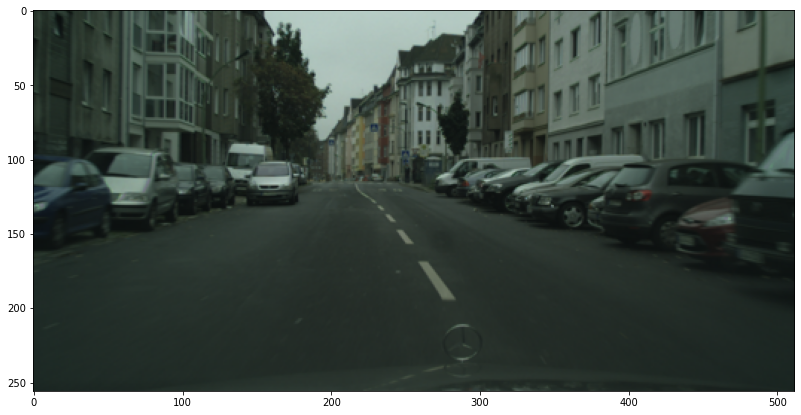

In [7]:
test_img = visualize(img_ds[4]).unsqueeze(0)

print("min:", test_img.min())
print("max:", test_img.max())

plt.figure(figsize=(15, 7))
plt.imshow(test_img.squeeze(0).permute(1, 2, 0))

# Create the model

In [ ]:
# https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py
# https://medium.com/@tioluwaniaremu/vgg-16-a-simple-implementation-using-pytorch-7850be4d14a1

# State-of-the-art: https://paperswithcode.com/paper/mask-dino-towards-a-unified-transformer-based-1
class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, 
                              out_channels=out_channels, 
                              kernel_size=3, 
                              stride=2, 
                              padding=padding)
        
    def forward(self, x):
        x = self.conv(x)
        return F.relu(x)
    
class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels, padding=1):
        super().__init__()
        self.upconv = nn.ConvTranspose2d(in_channels=in_channels, 
                                         out_channels=out_channels, 
                                         kernel_size=3, 
                                         stride=2, 
                                         padding=padding, 
                                         output_padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        x = self.upconv(x)
        x = self.bn(x)
        return F.relu(x)
    
class Encoder(nn.Module):
    def __init__(self, depth, initial_channels=16):
        super().__init__()
        self.ds1 = Downsample(in_channels=3, out_channels=initial_channels, padding=1)
        pow_2 = int(np.log2(initial_channels))
        self.dss = nn.ModuleList([Downsample(in_channels=2**x, out_channels=2**(x+1), padding=1) for x in range(pow_2, pow_2 + depth)])
        
    def forward(self, x):
        x = self.ds1(x)
        for ds in self.dss:
            x = ds(x)
        return x
        
class LatentEnc(nn.Module):
    def __init__(self, depth, latent_dim=512, initial_channels=16):
        super().__init__()
        pow_2 = int(np.log2(initial_channels))
        w, h, channels = IMAGE_W // (2**(depth+1)), IMAGE_H // (2**(depth+1)), 2**(pow_2+depth)
        self.lin1 = nn.Linear(w * h * channels, w * h * channels // 2)
        self.lin2 = nn.Linear(w * h * channels // 2, latent_dim)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.relu(x)
        return x
    
class LatentDec(nn.Module):
    def __init__(self, depth, latent_dim=512, initial_channels=16):
        super().__init__()
        pow_2 = int(np.log2(initial_channels))
        w, h, channels = IMAGE_W // (2**(depth+1)), IMAGE_H // (2**(depth+1)), 2**(pow_2+depth)
        self.lin1 = nn.Linear(latent_dim, w * h * channels // 2)
        self.lin2 = nn.Linear(w * h * channels // 2, w * h * channels)
        self.unflatten_shape = (channels, h, w)
    
    def forward(self, x):
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.relu(x)
        x = x.view(-1, *self.unflatten_shape)
        return x
    
class Decoder(nn.Module):
    def __init__(self, depth, initial_channels=16):
        super().__init__()
        pow_2 = int(np.log2(initial_channels))
        self.uss = nn.ModuleList([Upsample(in_channels=2**(x+1), out_channels=2**x, padding=1) for x in reversed(range(pow_2, pow_2 + depth))])
        self.us1 = Upsample(in_channels=initial_channels, out_channels=3, padding=1)
        
    def forward(self, x):
        for us in self.uss:
            x = us(x)
        x = self.us1(x)
        return x
    
class Model(nn.Module):
    def __init__(self, depth=6, intial_channels=8):
        super().__init__()
        self.encoder = Encoder(depth=depth, initial_channels=intial_channels)
#         self.latent_enc = LatentEnc(depth=depth, initial_channels=intial_channels)
#         self.latent_dec = LatentDec(depth=depth, initial_channels=intial_channels)
        self.decoder = Decoder(depth=depth, initial_channels=intial_channels)
        
    def forward(self, x):
        x = self.encoder(x)
#         x = self.latent_enc(x)
#         x = self.latent_dec(x)
        x = self.decoder(x)
        return x
        
DEPTH = 5
INTIAL_CHANNELS = 32
    
# print(f"Original\t{test_img.shape}")
# enc_out = Encoder(depth=DEPTH, initial_channels=INTIAL_CHANNELS)(test_img)
# print(f"Encoder \t{enc_out.shape}")
# latent_enc_out = LatentEnc(depth=DEPTH, initial_channels=INTIAL_CHANNELS)(enc_out)
# print(f"LatentEnc\t{latent_enc_out.shape}")
# latent_dec_out = LatentDec(depth=DEPTH, initial_channels=INTIAL_CHANNELS)(latent_enc_out)
# print(f"LatentDec\t{latent_dec_out.shape}")
# dec_out = Decoder(depth=DEPTH, initial_channels=INTIAL_CHANNELS)(latent_dec_out)
# print(f"Decoder\t{dec_out.shape}")

print(f"Original\t{test_img.shape}")
out = Model(depth=DEPTH, intial_channels=INTIAL_CHANNELS)(test_img)
print(f"Model out\t{out.shape}")

In [9]:
summary(Model(depth=DEPTH, intial_channels=INTIAL_CHANNELS).cuda(), input_size=(3, 256, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 256]             896
        Downsample-2         [-1, 32, 128, 256]               0
            Conv2d-3          [-1, 64, 64, 128]          18,496
        Downsample-4          [-1, 64, 64, 128]               0
            Conv2d-5          [-1, 128, 32, 64]          73,856
        Downsample-6          [-1, 128, 32, 64]               0
            Conv2d-7          [-1, 256, 16, 32]         295,168
        Downsample-8          [-1, 256, 16, 32]               0
            Conv2d-9           [-1, 512, 8, 16]       1,180,160
       Downsample-10           [-1, 512, 8, 16]               0
           Conv2d-11           [-1, 1024, 4, 8]       4,719,616
       Downsample-12           [-1, 1024, 4, 8]               0
          Encoder-13           [-1, 1024, 4, 8]               0
  ConvTranspose2d-14           [-1, 512

# Training Loop

In [10]:
BATCH_SIZE = 128
EPOCHS = 1000
LEARNING_RATE = 0.001

In [11]:
writer = SummaryWriter('runs/version1' + '_' + datetime.datetime.now().strftime("%d%m-%H%M%S"))

# intialize model
m = Model(depth=DEPTH, intial_channels=INTIAL_CHANNELS).cuda()

# initialize optimizer 
optim = torch.optim.Adam(m.parameters(), lr=LEARNING_RATE)

# dataloader 
dl_train = torch.utils.data.DataLoader(ImageDataset(train_val_test=0), batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

# set up validation datasets and validation images
val_ds = ImageDataset(train_val_test=1)
dl_val = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

val_img1, val_img2, val_img3 = val_ds[14], val_ds[307], val_ds[450]

grid = torch.zeros((3, 256 * 2, 512 * 3))
grid[:, :256, 0:512] = visualize(val_img1)
grid[:, :256, 512:512*2] = visualize(val_img2)
grid[:, :256, 512*2:512*3] = visualize(val_img3)

val_set = torch.stack((val_img1, val_img2, val_img3))

# loss function
criterion = torch.nn.MSELoss()

for epoch in range(EPOCHS):
    loss_sum = 0
    t1 = time.time()
    for i, batch in enumerate(dl_train):
        # zero the gradient
        optim.zero_grad()
        # put the batch on GPU
        batch = batch.cuda()
        # forward pass
        out = m(batch)
        # calculate loss
        loss = criterion(out, batch)
        # backward pass
        loss.backward()
        # update the weights
        optim.step()
        # add loss to loss sum
        loss_sum += loss.item()
    
    with torch.no_grad():
        # validation and metric logging
        train_loss = loss_sum / len(dl_train)
        val_loss = 0
        
        # calculate validation loss
        for batch in dl_val:
            batch = batch.cuda()
            # forward pass
            out = m(batch)
            # calculate loss
            loss = criterion(out, batch)
            # add loss to loss sum
            val_loss += loss.item()
        
        # average the validation loss
        val_loss /= len(dl_val)
        # create validation images
        val_out = m(val_set.cuda())
    
        grid[:, 256:, 0:512] = torch.clamp(visualize(val_out[0]), 0, 1)
        grid[:, 256:, 512:512*2] = torch.clamp(visualize(val_out[1]), 0, 1)
        grid[:, 256:, 512*2:512*3] = torch.clamp(visualize(val_out[2]), 0, 1)

        writer.add_image('images', grid, epoch)
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Val/train', val_loss, epoch)

        print(f"[{epoch + 1}/{EPOCHS}]\t({time.time() - t1:.2f}s)\tloss: {train_loss:.4f}\tval_loss: {val_loss:.4f}")

[1/1000]	(14.25s)	loss: 0.7717	val_loss: 0.6689
[2/1000]	(14.13s)	loss: 0.5877	val_loss: 0.6004
[3/1000]	(14.34s)	loss: 0.5489	val_loss: 0.5726
[4/1000]	(15.12s)	loss: 0.5252	val_loss: 0.5482
[5/1000]	(14.64s)	loss: 0.5111	val_loss: 0.5319
[6/1000]	(14.94s)	loss: 0.4969	val_loss: 0.5225
[7/1000]	(14.25s)	loss: 0.4905	val_loss: 0.5164
[8/1000]	(14.19s)	loss: 0.4860	val_loss: 0.5102
[9/1000]	(14.28s)	loss: 0.4819	val_loss: 0.5057
[10/1000]	(14.29s)	loss: 0.4756	val_loss: 0.4988
[11/1000]	(14.39s)	loss: 0.4715	val_loss: 0.4949
[12/1000]	(14.19s)	loss: 0.4688	val_loss: 0.4922
[13/1000]	(14.34s)	loss: 0.4652	val_loss: 0.4872
[14/1000]	(14.33s)	loss: 0.4613	val_loss: 0.4848
[15/1000]	(14.21s)	loss: 0.4603	val_loss: 0.4845
[16/1000]	(14.25s)	loss: 0.4581	val_loss: 0.4773
[17/1000]	(13.87s)	loss: 0.4512	val_loss: 0.4741
[18/1000]	(14.50s)	loss: 0.4503	val_loss: 0.4683
[19/1000]	(14.41s)	loss: 0.4464	val_loss: 0.4659
[20/1000]	(14.22s)	loss: 0.4436	val_loss: 0.4644
[21/1000]	(14.10s)	loss: 0.44

[168/1000]	(13.84s)	loss: 0.3596	val_loss: 0.3692
[169/1000]	(13.66s)	loss: 0.3575	val_loss: 0.3681
[170/1000]	(13.68s)	loss: 0.3588	val_loss: 0.3681
[171/1000]	(13.66s)	loss: 0.3583	val_loss: 0.3695
[172/1000]	(13.73s)	loss: 0.3572	val_loss: 0.3682
[173/1000]	(13.54s)	loss: 0.3571	val_loss: 0.3676
[174/1000]	(13.66s)	loss: 0.3580	val_loss: 0.3672
[175/1000]	(13.56s)	loss: 0.3569	val_loss: 0.3683
[176/1000]	(13.54s)	loss: 0.3583	val_loss: 0.3674
[177/1000]	(13.53s)	loss: 0.3563	val_loss: 0.3693
[178/1000]	(13.78s)	loss: 0.3578	val_loss: 0.3670
[179/1000]	(13.62s)	loss: 0.3571	val_loss: 0.3668
[180/1000]	(13.66s)	loss: 0.3574	val_loss: 0.3678
[181/1000]	(13.61s)	loss: 0.3584	val_loss: 0.3682
[182/1000]	(13.76s)	loss: 0.3568	val_loss: 0.3673
[183/1000]	(13.63s)	loss: 0.3583	val_loss: 0.3669
[184/1000]	(13.66s)	loss: 0.3574	val_loss: 0.3686
[185/1000]	(13.85s)	loss: 0.3574	val_loss: 0.3676
[186/1000]	(15.00s)	loss: 0.3564	val_loss: 0.3674
[187/1000]	(14.58s)	loss: 0.3562	val_loss: 0.3663


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa4c0e5a3a0>
Traceback (most recent call last):
  File "/home/stef/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/home/stef/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1448, in _shutdown_workers
    q.close()
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 142, in close
    close()
  File "/usr/lib/python3.8/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 200, in _finalize_close
    @staticmethod
KeyboardInterrupt: 

KeyboardInterrupt



In [ ]:
plt.imshow(torch.clamp(visualize(m(img_ds[0].unsqueeze(0).cuda()).squeeze(0).detach().cpu()).permute(1, 2, 0), 0, 1))